In [2]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

from huggingface_hub import notebook_login

notebook_login()

In [3]:
import os, math, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator
from accelerate.utils import set_seed
from diffusers import (
    StableDiffusion3Pipeline,
    BitsAndBytesConfig,
    AutoencoderKL,
    SD3Transformer2DModel,
    FlowMatchEulerDiscreteScheduler
)
from diffusers.optimization import get_scheduler as get_lr_scheduler
from diffusers.training_utils import (
    compute_density_for_timestep_sampling,
    compute_loss_weighting_for_sd3
)
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict, PeftModel
from transformers import (
    CLIPTokenizer, CLIPTextModelWithProjection,
    T5TokenizerFast, T5EncoderModel
)
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm


In [18]:
style_name = "New_Realism"
# 可选风格 style_name
# ['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 
# 'Art_Nouveau', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism',
# 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance',
# 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism',
# 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism',
# 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e']
config = {
    "model_id": "stabilityai/stable-diffusion-3.5-medium",
    "style_dataset_id": "huggan/wikiart",
    "output_dir": "./sd3-lora-style",
    "seed": 42,
    "resolution": 512,
    "train_batch_size": 2,#保持2不动
    "gradient_accumulation": 1,
    "learning_rate": 1e-5,
    "num_train_epochs": 1,
    "num_train_steps": 300,
    "lr_scheduler_type": "linear",
    "lr_warmup_steps": 20,
    "lora_rank": 4,
    "lora_alpha": 8,
    "max_grad_norm": 1.0,
    "mixed_precision": "bf16", #['no', 'fp8', 'fp16', 'bf16']
    "weighting_scheme": "logit_normal",

    "with_prior_preservation": True,        # 是否使用先验保存损失
    "prior_loss_weight": 1.0,              # 先验损失权重
    "instance_prompt": f"a photo in the style of {style_name}", # 实例提示词
    "class_prompt": f"a photo in the style of {style_name}", # 类别提示词
    "num_class_images": 10,                # 生成的类别图像数量
    "class_data_dir": "./class_images"     # 类别图像保存路径
}


In [5]:
from PIL import Image
def image_grid(imgs, rows, cols, size=256):
    assert len(imgs) == rows * cols
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(img.resize((size, size), Image.LANCZOS))
    grid = Image.new("RGB", size=(cols * size, rows * size))
    for i, img in enumerate(resized_imgs):
        grid.paste(img, box=(i % cols * size, i // cols * size))
    return grid

In [6]:
#直接加载原始预训练模型
pipeline = StableDiffusion3Pipeline.from_pretrained(
"stabilityai/stable-diffusion-3.5-medium",
torch_dtype=torch.bfloat16,
cache_dir="models/huggingface"
)
pipeline.enable_attention_slicing()
pipeline.to("cuda")
transformer = pipeline.transformer

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [ ]:
# 加载完整的模型检查点
import os, gc
import torch
import torch.nn.functional as F
from accelerate import Accelerator
from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel, T5TokenizerFast, BitsAndBytesConfig
from diffusers import StableDiffusion3Pipeline, SD3Transformer2DModel, AutoencoderKL, FlowMatchEulerDiscreteScheduler

# 首先清理GPU内存
gc.collect()
torch.cuda.empty_cache()
print(f"初始GPU内存使用: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

# 设置基本参数
model_id = "stabilityai/stable-diffusion-3.5-medium"
dreambooth_dir = "./dreambooth-sd35"  # 检查点保存目录
latest_checkpoint = "checkpoint-tbhwbx-2000"  # 指定检查点名称
device = "cuda" if torch.cuda.is_available() else "cpu"

accelerator = Accelerator(
    mixed_precision=config["mixed_precision"],
    gradient_accumulation_steps=config["gradient_accumulation"]
)
transformer = SD3Transformer2DModel.from_pretrained(
    config["model_id"],
    subfolder="transformer",
    torch_dtype=torch.bfloat16
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_enable_fp32_cpu_offload=True
)
device_map = {
    # 只将必要的部分放在GPU上
    "shared": "cpu",
    "encoder.embed_tokens": "cpu",
    "encoder.block": "cpu",
    "encoder.final_layer_norm": "cpu"
}
text_encoder_3 = T5EncoderModel.from_pretrained(
    config["model_id"],
    subfolder="text_encoder_3",
    quantization_config=bnb_config,  
    device_map=device_map,
    torch_dtype=torch.bfloat16
)

# 加载检查点
checkpoint_path = os.path.join(dreambooth_dir, latest_checkpoint)
print(f"加载检查点: {checkpoint_path}")
accelerator.load_state(checkpoint_path)

# 获取unwrapped模型以构建pipeline
if accelerator.is_main_process:
    #可以只获取transformer部分
    unwrapped_transformer = accelerator.unwrap_model(transformer)
    print("构建StableDiffusion3Pipeline...")

    pipeline = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16,
    transformer=unwrapped_transformer,
    text_encoder_3=text_encoder_3
    )
    # pipeline.enable_model_cpu_offload()
    pipeline.enable_attention_slicing()
    try:
        pipeline.enable_xformers_memory_efficient_attention()
        print("已启用xFormers高效注意力")
    except:
        print("无法启用xFormers")
    pipeline.to(device)


In [7]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
print(f"当前分配的GPU内存: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"峰值保留: {torch.cuda.max_memory_reserved() / 1e9:.2f} GB")

当前分配的GPU内存: 16.32 GB
峰值保留: 16.59 GB


```
#从本地加载保存的模型，刚训练完可以跳过（或重启内核/清空cuda）
import os
import torch
import gc, re
from transformers import CLIPTokenizer, CLIPTextModel, T5EncoderModel, T5TokenizerFast
from transformers import BitsAndBytesConfig
from diffusers import SD3Transformer2DModel, StableDiffusion3Pipeline, BitsAndBytesConfig
from datetime import datetime

gc.collect()
torch.cuda.empty_cache()
print(f"清理后的GPU内存: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
output_dir = "./dreambooth-sd35"

model_dirs = [d for d in os.listdir(output_dir) if d.startswith("model_lr")]
transformer_dirs = [d for d in os.listdir(output_dir) if d.startswith("transformer_")]

def extract_timestamp(dirname):
    # 提取格式为YYYYMMDD_HHMMSS的时间戳
    match = re.search(r'(\d{8}_\d{6})', dirname)
    if match:
        return datetime.strptime(match.group(1), '%Y%m%d_%H%M%S')
    return datetime(1970, 1, 1)

latest_model = sorted(model_dirs, key=extract_timestamp)[-1]
# latest_transformer = sorted(transformer_dirs, key=extract_timestamp)[-1]
# latest_model = "model_lr_bydxt_2.0em06_2000steps_20250514_133407"

model_path = os.path.join(output_dir, latest_model)
# transformer_path = os.path.join(output_dir, latest_transformer)
print(f"正在加载模型: {model_path}")

#单独加载transformer
# bnb_config = BitsAndBytesConfig(load_in_8bit=True)
transformer = SD3Transformer2DModel.from_pretrained(
    model_path,
    subfolder="transformer",
    torch_dtype=torch.bfloat16,
)
text_encoder = CLIPTextModel.from_pretrained(
    model_path,
    subfolder="text_encoder",
    torch_dtype=torch.bfloat16
)
text_encoder_2 = CLIPTextModel.from_pretrained(
    model_path,
    subfolder="text_encoder_2",
    torch_dtype=torch.bfloat16
)
#组装 Pipeline（其余组件全精度加载）
pipeline = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16,
    transformer=transformer,
    text_encoder=text_encoder,
    text_encoder_2=text_encoder_2,
)
pipeline.enable_model_cpu_offload()
pipeline.enable_attention_slicing()
try:
    pipeline.enable_xformers_memory_efficient_attention()
    print("已启用xFormers高效注意力机制")
except Exception:
    print("xFormers不可用，使用标准注意力机制")

pipeline.to("cuda")

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torchvision import transforms

# style_name = "Realism"
# 可选风格 style_name
# ['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 
# 'Art_Nouveau', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism',
# 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance',
# 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism',
# 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism',
# 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e']

class StyleWithClassDataset(Dataset):
    def __init__(
        self,
        hf_id: str,
        class_data_dir: str = None,
        split: str = "train",
        resolution: int = 512,
        style_limit: int = 50,
        style_name: str = "Impressionism",
    ):
        # 加载风格实例图像
        self.ds = load_dataset(
            hf_id,
            split=split,
            streaming=True
        )
        style_feature = self.ds.features["style"]
        style_names = style_feature.names
        try:
            self.target_idx = style_names.index(style_name)
        except ValueError:
            raise ValueError(f"Style '{style_name}' not in available styles: {style_names}")

        # 收集实例(风格)图像
        self.instance_images = []
        for ex in self.ds:
            if ex["style"] == self.target_idx:
                self.instance_images.append(ex["image"])
                if len(self.instance_images) >= style_limit:
                    break
        if not self.instance_images:
            raise ValueError(f"No images found for style '{style_name}'")

        # 收集类别图像(如果提供)
        self.class_images = None
        if class_data_dir and os.path.exists(class_data_dir):
            self.class_images = [
                os.path.join(class_data_dir, f) 
                for f in os.listdir(class_data_dir)
                if f.lower().endswith(("jpg", "png", "jpeg"))
            ]

        # 计算数据集大小
        self.num_instance_images = len(self.instance_images)
        self.num_class_images = 0 if self.class_images is None else len(self.class_images)
        self._length = self.num_instance_images + self.num_class_images
        
        # 图像转换
        self.transform = transforms.Compose([
            transforms.Resize(resolution),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]
            ),
        ])
        
    def __len__(self):
        return self._length

    def __getitem__(self, idx):
        # 实例图片
        if idx < self.num_instance_images:
            img = self.instance_images[idx]
            if not isinstance(img, Image.Image):
                img = Image.open(img).convert("RGB")
            is_class = False
        # 类别图片
        else:
            img_path = self.class_images[idx - self.num_instance_images]
            img = Image.open(img_path).convert("RGB")
            is_class = True
            
        return {
            "pixel_values": self.transform(img),
            "is_class": is_class
        }
    
class StyleDataset(Dataset):
    def __init__(
        self,
        hf_id: str,
        split: str = "train",
        resolution: int = 512,
        limit: int = 50,
        style_name: str = "Impressionism",
    ):
        ds = load_dataset( # 加载数据集（流式模式）
            hf_id,
            split=split,
            streaming=True,
            cache_dir="./datasets"
        )
        style_feature = ds.features["style"]
        style_names = style_feature.names
        try:
            target_idx = style_names.index(style_name)
        except ValueError:
            raise ValueError(f"Style '{style_name}' not in available styles: {style_names}")

        self.images = []
        for ex in ds:
            if ex["style"] == target_idx:
                self.images.append(ex["image"])
                if len(self.images) >= limit:
                    break
        if not self.images:
            raise ValueError(f"No images found for style '{style_name}'")

        self.transform = transforms.Compose([
            transforms.Resize(resolution),
            transforms.CenterCrop(resolution),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]
            ),
        ])
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if not isinstance(img, Image.Image):
            img = Image.open(img).convert("RGB")
        return {"pixel_values": self.transform(img)}

In [9]:
import os, tqdm
from pathlib import Path

def generate_class_images(
    class_prompt,
    class_data_dir,
    num_class_images,
    device,
    guidance_scale=5.0,
    num_inference_steps=40,
    pipe=None
):
    """生成类别图片"""
    os.makedirs(class_data_dir, exist_ok=True)
    
    # 检查目录中图片数量，如果已足够则跳过
    class_images_available = len(list(Path(class_data_dir).iterdir()))
    if class_images_available >= num_class_images:
        print(f"已找到 {class_images_available} 张类别图片，跳过生成")
        return
    
    # 创建临时pipeline用于生成类别图片
    print(f"开始生成 {num_class_images} 张类别图片...")
    gen_pipe = pipe if pipe else StableDiffusion3Pipeline.from_pretrained(
        config["model_id"],
        torch_dtype=torch.bfloat16,
    ).to(device)
    gen_pipe.enable_attention_slicing()
    
    # 批量生成
    num_existing = len(os.listdir(class_data_dir))
    batch_size = 1  # SD3.5对内存要求高，每次只生成一张
    
    with torch.no_grad():
        for i in tqdm.tqdm(range(0, num_class_images - num_existing, batch_size)):
            # 确定本批次实际生成数量
            current_batch_size = min(batch_size, num_class_images - num_existing - i)
            
            # 生成图片
            images = gen_pipe(
                prompt=[class_prompt] * current_batch_size,
                guidance_scale=guidance_scale,
                num_inference_steps=num_inference_steps,
                generator=torch.Generator(device=device).manual_seed(i + config["seed"])
            ).images
            
            # 保存图片
            for j, img in enumerate(images):
                img_index = num_existing + i + j
                img.save(os.path.join(class_data_dir, f"class_image_{img_index:05d}.jpg"))
    
    print(f"类别图片生成完成，共 {len(os.listdir(class_data_dir))} 张")
    
    # 如果是创建的临时pipeline，释放内存
    if pipe is None:
        del gen_pipe
        gc.collect()
        torch.cuda.empty_cache()

In [10]:
def collate_fn(examples):
    """整合批次数据，保留类别信息"""
    pixel_values = torch.stack([e["pixel_values"] for e in examples])
    
    # 标记哪些是类别图片
    is_class = torch.tensor([e["is_class"] for e in examples], dtype=torch.bool)
    
    return {"pixel_values": pixel_values, "is_class": is_class}

In [11]:
lora_config = LoraConfig(
    r=config["lora_rank"],
    lora_alpha=config["lora_alpha"],
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0,
    bias="none",
)
transformer = get_peft_model(transformer, lora_config)
peft_model: PeftModel = transformer
pipeline.transformer = transformer

In [13]:
accelerator = Accelerator(
    mixed_precision=config["mixed_precision"],
    gradient_accumulation_steps=config["gradient_accumulation"]
)
# 在训练之前生成类别图片
if config["with_prior_preservation"]:
    class_data_dir = os.path.join(config["output_dir"], "class_images", style_name)
    generate_class_images(
        class_prompt=config["class_prompt"],
        class_data_dir=class_data_dir,
        num_class_images=config["num_class_images"],
        device=accelerator.device,
        pipe=pipeline
    )
    
    # 使用支持类别图像的数据集
    style_ds = StyleWithClassDataset(
        hf_id=config["style_dataset_id"],
        class_data_dir=class_data_dir,
        split="train",
        resolution=config["resolution"],
        style_limit=50,
        style_name=style_name
    )
else:
    # 使用原始的风格数据集
    style_ds = StyleDataset(
        hf_id=config["style_dataset_id"],
        split="train",
        resolution=config["resolution"],
        limit=50,
        style_name=style_name
    )
    
train_loader = DataLoader(
    style_ds,
    batch_size=config["train_batch_size"],
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn=collate_fn if config["with_prior_preservation"] else None
)

已找到 11 张类别图片，跳过生成


Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

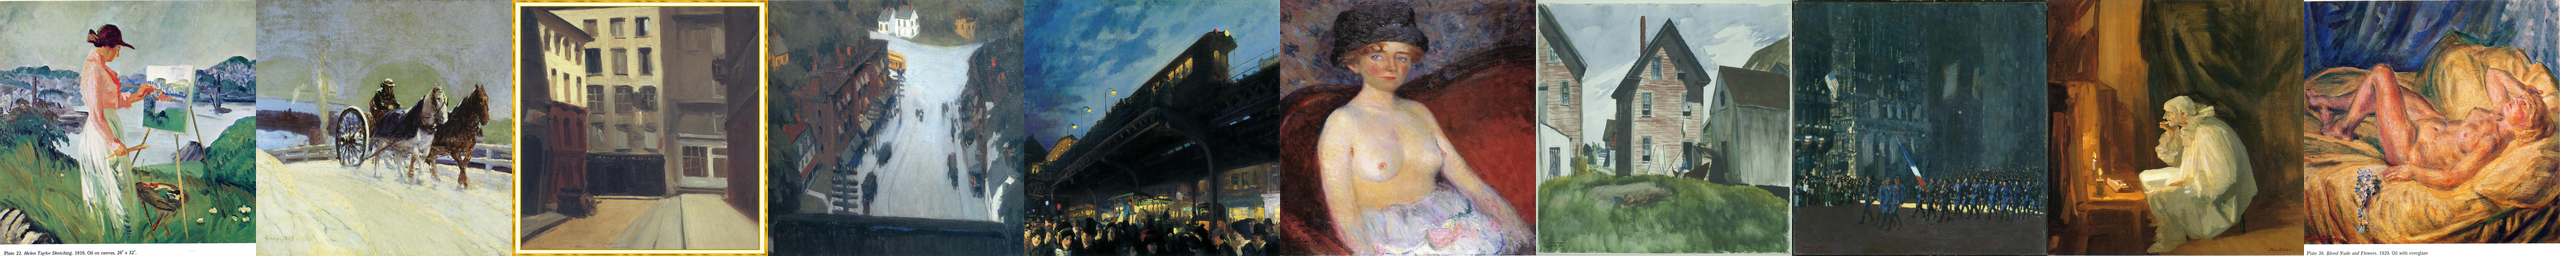

In [15]:
from IPython.display import display
# 收集前10张原始PIL格式图像
pil_images = []
for i in range(min(10, len(style_ds.instance_images))):
    img = style_ds.instance_images[i]
    if not isinstance(img, Image.Image):
        img = Image.open(img).convert("RGB")
    pil_images.append(img)
    
grid = image_grid(pil_images, rows=1, cols=10, size=256)
display(grid)

In [16]:
import bitsandbytes as bnb
set_seed(config["seed"])
# accelerator = Accelerator(
#     mixed_precision=config["mixed_precision"],
#     gradient_accumulation_steps=config["gradient_accumulation"]
# )
# 优化 LoRA 参数
# optimizer = bnb.optim.Adam8bit(
#     transformer.parameters(), lr=config["learning_rate"]
# )
optimizer = torch.optim.AdamW(
    transformer.parameters(), lr=config["learning_rate"]
)
# 学习率调度器
lr_scheduler = get_lr_scheduler(
    config["lr_scheduler_type"], optimizer,
    num_warmup_steps=config["lr_warmup_steps"],
    num_training_steps=config["num_train_steps"]
)

# Accelerator 包装

vae = pipeline.vae
text_encoder = pipeline.text_encoder
text_encoder_2 = pipeline.text_encoder_2
scheduler = pipeline.scheduler

vae.to(accelerator.device, dtype=torch.bfloat16)
text_encoder.to(accelerator.device)
text_encoder_2.to(accelerator.device)

transformer, text_encoder, text_encoder_2, optimizer, train_loader, lr_scheduler = accelerator.prepare(
    transformer,  text_encoder, text_encoder_2, optimizer, train_loader, lr_scheduler
)

### LoRA训练

In [19]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from diffusers.training_utils import (
    compute_density_for_timestep_sampling,
    compute_loss_weighting_for_sd3
)
# 训练前初始化
loss_history = []
global_step = 0
transformer.train()
progress_bar = tqdm(total=config["num_train_steps"], desc="LoRA 风格迁移训练", 
                    disable=not accelerator.is_local_main_process)

# 训练前预计算
latents_cache = []
class_mask = []
print("预计算VAE编码...")
vae.to(accelerator.device)  # 保持VAE在GPU上
for batch in tqdm(train_loader, desc="缓存VAE编码"):
    with torch.no_grad():
        pixel_values = batch["pixel_values"].to(accelerator.device, dtype=torch.bfloat16)
        latent = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor
        batch_size = latent.shape[0]
        
        # 存储潜空间编码
        latents_cache.append(latent.cpu())  
        
        # 确保class_mask有相同数量的元素
        if config["with_prior_preservation"]:
            if "is_class" in batch and batch["is_class"].shape[0] == batch_size:
                class_mask.append(batch["is_class"].cpu())
            else:
                class_mask.append(torch.zeros(batch_size, dtype=torch.bool))

# 构建新数据集
from torch.utils.data import TensorDataset, DataLoader
# 构建新数据集时检查长度
if config["with_prior_preservation"]:
    # 验证形状匹配
    all_latents = torch.cat(latents_cache)
    all_masks = torch.cat(class_mask)
    
    if all_latents.shape[0] != all_masks.shape[0]:
        print(f"警告: 潜空间形状 {all_latents.shape[0]} 与类掩码形状 {all_masks.shape[0]} 不匹配")
        # 填充缺失的掩码 (如果latents更多)
        if all_latents.shape[0] > all_masks.shape[0]:
            padding = torch.zeros(all_latents.shape[0] - all_masks.shape[0], dtype=torch.bool)
            all_masks = torch.cat([all_masks, padding])
        # 截断掩码 (如果掩码更多)
        else:
            all_masks = all_masks[:all_latents.shape[0]]
        
    latents_dataset = TensorDataset(all_latents, all_masks)
else:
    latents_dataset = TensorDataset(torch.cat(latents_cache))
    
cached_dataloader = DataLoader(latents_dataset, batch_size=config["train_batch_size"], shuffle=True)

prompts_instance = [config["instance_prompt"]] * config["train_batch_size"]
prompts_class = [config["class_prompt"]] * config["num_class_images"] if config["with_prior_preservation"] else None
# 传入三路文本编码器, 不训练文本编码器时使用
# 分别准备实例提示词和类别提示词的嵌入
instance_prompt_embeds, _, instance_pooled_embeds, _ = pipeline.encode_prompt(
    prompts_instance, prompts_instance, prompts_instance,
    do_classifier_free_guidance=False,
    num_images_per_prompt=1
)
instance_prompt_embeds = instance_prompt_embeds.detach()
instance_pooled_embeds = instance_pooled_embeds.detach()

# 处理类别提示词嵌入 - 采用分批处理
if config["with_prior_preservation"]:
    batch_size = 1  # 每批处理1个提示词
    
    # 初始化存储
    all_class_prompt_embeds = []
    all_class_pooled_embeds = []
    
    # 分批处理类别提示词
    for i in range(0, len(prompts_class), batch_size):
        # 清理GPU内存
        gc.collect()
        torch.cuda.empty_cache()
        
        # 获取当前批次的提示词
        batch_prompts = prompts_class[i:i+batch_size]
        
        # 为当前批次生成嵌入
        # print(f"处理类别提示词批次 {i//batch_size + 1}/{(len(prompts_class)-1)//batch_size + 1}")
        
        try:
            with torch.inference_mode():
                batch_embeds, _, batch_pooled, _ = pipeline.encode_prompt(
                    batch_prompts, batch_prompts, batch_prompts,
                    do_classifier_free_guidance=False,
                    num_images_per_prompt=1
                )
                
            # 收集结果 - 立即转移到CPU以减少GPU内存占用
            all_class_prompt_embeds.append(batch_embeds.cpu())
            all_class_pooled_embeds.append(batch_pooled.cpu())
        
        except Exception as e:
            print(f"处理批次 {i//batch_size + 1} 时出错: {e}")
            # 继续处理下一批
            continue
    
    # 合并所有批次结果
    torch.cuda.empty_cache()
    
    if all_class_prompt_embeds:
        class_prompt_embeds = torch.cat(all_class_prompt_embeds, dim=0).detach()
        class_pooled_embeds = torch.cat(all_class_pooled_embeds, dim=0).detach()
        
        # 只保留所需数量的嵌入，并转移到GPU
        needed_count = min(config["train_batch_size"], class_prompt_embeds.shape[0])
        class_prompt_embeds = class_prompt_embeds[:needed_count].to(accelerator.device)
        class_pooled_embeds = class_pooled_embeds[:needed_count].to(accelerator.device)

        class_prompt_embeds = class_prompt_embeds.detach()
        class_pooled_embeds = class_pooled_embeds.detach()
    else:
        print("警告：无法生成任何类别提示词嵌入，使用实例嵌入代替")
        class_prompt_embeds = instance_prompt_embeds.clone()
        class_pooled_embeds = instance_pooled_embeds.clone()

for param in vae.parameters(): param.requires_grad = False

num_batches = len(cached_dataloader)
num_epochs = (config["num_train_steps"]*config["gradient_accumulation"]) // num_batches +1
print(f"将训练 {num_epochs} 个epoch，总计 {config["num_train_steps"]} 步")

for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(cached_dataloader):
        with accelerator.accumulate(transformer):
            
            latents = batch[0].to(accelerator.device)
            is_class = batch[1].to(accelerator.device) if config["with_prior_preservation"] else None
            bsz = latents.shape[0]

            # 流匹配前向扩散
            noise = torch.randn_like(latents)
            u = compute_density_for_timestep_sampling(
                weighting_scheme="logit_normal",
                batch_size=bsz,
                logit_mean=0.0,     # SD3-paper 中的 mu, sigma，可用 None 触发默认
                logit_std=1.0,
                mode_scale=None
            ).to(latents.device)
            timesteps_tensor = scheduler.timesteps.to(latents.device)
            idx = (u * (scheduler.config.num_train_timesteps - 1)).long().to(latents.device)
            timesteps = timesteps_tensor[idx]
            # 取出 σ_t
            sigmas = scheduler.sigmas.to(latents.device)[idx].view(bsz, *([1] * (latents.ndim - 1)))
            noisy_latents = (1 - sigmas) * latents + sigmas * noise

            if config["with_prior_preservation"] and is_class is not None:
                # 准备批次的文本嵌入
                is_class_cpu = is_class.cpu()
                
                # 批次类型判断
                if is_class_cpu.all().item():  # 全是类别样本
                    batch_prompt_embeds = class_prompt_embeds.clone()
                    batch_pooled_embeds = class_pooled_embeds.clone()
                elif (~is_class_cpu).all().item():  # 全是实例样本  
                    batch_prompt_embeds = instance_prompt_embeds.clone()
                    batch_pooled_embeds = instance_pooled_embeds.clone()
                else:  # 混合批次
                    # 确保我们只使用第一个嵌入作为模板
                    instance_template = instance_prompt_embeds[0:1]  # [1, seq_len, dim]
                    class_template = class_prompt_embeds[0:1]        # [1, seq_len, dim]
                    instance_pooled_template = instance_pooled_embeds[0:1] 
                    class_pooled_template = class_pooled_embeds[0:1]
                    
                    # 初始化批次嵌入
                    batch_prompt_embeds = torch.zeros(
                        (bsz,) + instance_prompt_embeds.shape[1:], 
                        device=accelerator.device,
                        dtype=instance_prompt_embeds.dtype
                    )
                    batch_pooled_embeds = torch.zeros(
                        (bsz,) + instance_pooled_embeds.shape[1:],
                        device=accelerator.device, 
                        dtype=instance_pooled_embeds.dtype
                    )
                    
                    # 逐个位置填充
                    for i in range(bsz):
                        if is_class[i]:
                            batch_prompt_embeds[i] = class_template[0]
                            batch_pooled_embeds[i] = class_pooled_template[0]
                        else:
                            batch_prompt_embeds[i] = instance_template[0]
                            batch_pooled_embeds[i] = instance_pooled_template[0]
            else:
                # 不使用先验保存，全部使用实例嵌入
                batch_prompt_embeds = instance_prompt_embeds
                batch_pooled_embeds = instance_pooled_embeds
                
            if batch_pooled_embeds.shape[0] != bsz:
                if batch_pooled_embeds.shape[0] == 1:
                    batch_pooled_embeds = batch_pooled_embeds.expand(bsz, -1)
                else:
                    batch_pooled_embeds = batch_pooled_embeds[:bsz]
            
            if batch_prompt_embeds.shape[0] != bsz:
                if batch_prompt_embeds.shape[0] == 1:
                    batch_prompt_embeds = batch_prompt_embeds.expand(bsz, -1, -1)
                else:
                    batch_prompt_embeds = batch_prompt_embeds[:bsz]
            
            if isinstance(timesteps, torch.Tensor) and len(timesteps.shape) > 0:
                if timesteps.shape[0] != bsz:
                    first_timestep = timesteps[0].item()
                    timesteps = torch.full((bsz,), first_timestep, 
                                          device=timesteps.device, 
                                          dtype=timesteps.dtype)
            
            model_pred = transformer(
                hidden_states=noisy_latents,
                timestep=timesteps,
                encoder_hidden_states=batch_prompt_embeds,
                pooled_projections=batch_pooled_embeds,
                return_dict=False,
            )[0]
        
            # 预条件化
            model_pred = model_pred * (-sigmas) + noisy_latents
            # 计算损失
            loss_weights = compute_loss_weighting_for_sd3(
                weighting_scheme="sigma_sqrt",  # 或 "cosmap" / "none"
                sigmas=sigmas
            ).view(bsz, *([1] * (latents.ndim - 1)))

            if config["with_prior_preservation"] and is_class is not None:
                # 检查批次中是否既有实例图像也有类别图像
                has_instance = torch.any(~is_class).item()
                has_class = torch.any(is_class).item()
                
                if has_instance and has_class:
                    # 同时包含实例图像和类别图像的情况
                    # 分离实例数据和类别数据的预测
                    instance_pred = model_pred[~is_class]
                    class_pred = model_pred[is_class]
                    
                    # 分离实例数据和类别数据的目标
                    instance_target = (-latents)[~is_class]
                    class_target = (-latents)[is_class]
                    
                    # 分离损失权重
                    instance_weights = loss_weights[~is_class]
                    class_weights = loss_weights[is_class]
                    
                    # 计算实例损失
                    instance_loss = F.mse_loss(instance_pred.float(), instance_target.float(), reduction="none")
                    instance_loss = (instance_loss * instance_weights).mean()
                    
                    # 计算先验保存损失
                    prior_loss = F.mse_loss(class_pred.float(), class_target.float(), reduction="none")
                    prior_loss = (prior_loss * class_weights).mean()
                    
                    # 组合损失
                    prior_loss_weight = config.get("prior_loss_weight", 1.0)
                    loss = instance_loss + prior_loss_weight * prior_loss
                    
                    instance_loss_value = instance_loss.item()
                    prior_loss_value = prior_loss.item()
                else:
                    # 批次中只有一种类型的图像，使用常规损失计算
                    # print(f"批次中只包含{'类别' if has_class else '实例'}图像，使用常规损失计算")
                    loss = F.mse_loss(model_pred.float(), (-latents).float(), reduction="none")
                    loss = (loss * loss_weights).mean()
                    
                    # 记录损失值
                    if has_class:
                        instance_loss_value = 0.0
                        prior_loss_value = loss.item()
                    else:
                        instance_loss_value = loss.item()
                        prior_loss_value = 0.0
            else:
                # 普通损失计算（无先验保存）
                loss = F.mse_loss(model_pred.float(), (-latents).float(), reduction="none")
                loss = (loss * loss_weights).mean()
                instance_loss_value = None
                prior_loss_value = None

            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            
        current_loss = loss.detach().item()

        # if global_step > 0 and global_step % 500 == 0:
        #     checkpoint_path = os.path.join(
        #         config["output_dir"], 
        #         f"lora_checkpoint_dreambooth_{style_name}_{global_step}")
        #     os.makedirs(checkpoint_path, exist_ok=True)
        #     peft_model.save_pretrained(checkpoint_path)
        #     print(f"保存检查点到: {checkpoint_path}")

        if accelerator.sync_gradients:
            global_step += 1
            if accelerator.is_main_process:
                loss_history.append(current_loss)
            
            postfix_dict = {
                "loss": f"{current_loss:.4f}",
                "epoch": f"{epoch+1}/{num_epochs}"
            }
            if config["with_prior_preservation"] and instance_loss_value is not None:
                postfix_dict.update({
                    "inst_loss": f"{instance_loss_value:.4f}",
                    "prior_loss": f"{prior_loss_value:.4f}"
                })
            progress_bar.update(1)
            progress_bar.set_postfix(postfix_dict)

        if global_step >= config["num_train_steps"]:
            break
progress_bar.close()
# 保存最终检查点与LoRA权重
transformer = accelerator.unwrap_model(transformer)

# 保存LoRA权重
lora_save_path = os.path.join(config["output_dir"], f"lora_checkpoint_dreambooth_{style_name}_{config['learning_rate']:.1e}_{config["num_train_steps"]}steps")
os.makedirs(lora_save_path, exist_ok=True)
peft_model.save_pretrained(lora_save_path)


if len(loss_history) > 0 and accelerator.is_main_process:
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title(f'LoRA Style Transfer Training Loss\nLearning Rate: {config["learning_rate"]:.1e}')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss Value')
    plt.grid(True)
    
    plt.text(0.98, 0.02, f"learning rate: {config['learning_rate']:.1e}", 
             ha='right', va='bottom', transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

    filename = f"lora_style_loss_{style_name}_{config['learning_rate']:.1e}_{config["num_train_steps"]}steps.png"
    filename = filename.replace('+', 'p').replace('-', 'm')
    
    loss_dir = os.path.join(config["output_dir"], "loss_curves")
    os.makedirs(loss_dir, exist_ok=True)
    save_path_img = os.path.join(loss_dir, filename)
    plt.savefig(save_path_img, dpi=300)
    plt.show()
    
    print(f"损失曲线已保存至: {save_path_img}")

print(f"LoRA 风格迁移完成，权重保存在 {lora_save_path}")

LoRA 风格迁移训练:   0%|          | 0/300 [00:00<?, ?it/s]

预计算VAE编码...


缓存VAE编码:   0%|          | 0/30 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [13]:
from datetime import datetime

transformer = accelerator.unwrap_model(transformer)
# transformer_lora_state = get_peft_model_state_dict(transformer)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
formatted_lr = f"{config['learning_rate']:.1e}"
lora_save_path = os.path.join(
    config["output_dir"], 
    f"lora_weights_dreambooth_{style_name}_{formatted_lr}_{config['num_train_steps']}steps_{timestamp}"
)
os.makedirs(lora_save_path, exist_ok=True)
peft_model.save_pretrained(lora_save_path)
# pipeline.save_lora_weights(
#     save_directory=lora_save_path,
#     transformer_lora_layers=transformer_lora_state,
# )

print(f"LoRA 风格迁移完成，权重保存在: {lora_save_path}")

LoRA 风格迁移完成，权重保存在: ./sd3-lora-style\lora_weights_Realism_1.0e-05_1020steps_20250517_104651


In [1]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()
print(f"初始GPU内存使用: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

初始GPU内存使用: 0.00 GB


### lora加载和推理

In [ ]:
#先运行前三格
##可以加载dreambooth微调后的模型
print("正在加载基础模型...")
pipeline = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3.5-medium",
    torch_dtype=torch.bfloat16
)
pipeline.to("cuda")

# pipeline.enable_model_cpu_offload()
pipeline.enable_attention_slicing()
try:
    pipeline.enable_xformers_memory_efficient_attention()
    print("已启用xFormers高效注意力")
except:
    print("无法启用xFormers")

正在加载基础模型...


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


已启用xFormers高效注意力


In [5]:
import os, re
import torch
import gc
from diffusers import StableDiffusion3Pipeline
from PIL import Image
from datetime import datetime
from peft import PeftModel

gc.collect()
torch.cuda.empty_cache()
print(f"初始GPU内存使用: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

style_name = "Realism"
lora_dir = "./sd3-lora-style" #config["output_dir"]

def extract_timestamp(dirname):
    match = re.search(r'(\d{8}_\d{6})', dirname)
    if match:
        return datetime.strptime(match.group(1), '%Y%m%d_%H%M%S')
    return datetime(1970, 1, 1)

lora_dirs =[d for d in os.listdir(lora_dir) if d.startswith(f"lora_weights_dreambooth_{style_name}")]
latest_wehights = sorted(lora_dirs, key=extract_timestamp)[-1]
# latest_wehights = "lora_checkpoint_Realism_5.0e-05_1000steps"

lora_path = os.path.join(lora_dir, latest_wehights)

print(f"正在加载LoRA权重: {lora_path}")
peft_transformer: PeftModel = PeftModel.from_pretrained(pipeline.transformer, lora_path)
merged_transformer = peft_transformer.merge_and_unload()
pipeline.transformer = merged_transformer

# pipeline.load_lora_weights(lora_path, adapter_name=style_name)
# pipeline.fuse_lora()

# LoRA权重比例（1.0为完全应用）
# lora_scale = 1  # 0-1
# pipeline.set_adapters([style_name], adapter_weights=[lora_scale])

初始GPU内存使用: 18.33 GB
正在加载LoRA权重: ./sd3-lora-style\lora_weights_Realism_1.0e-05_1000steps_20250516_221442


#刚训练完可跳过加载部分运行此部分代码
lora_dir = "./sd3-lora-style"
merged_transformer=transformer.merge_and_unload()
pipeline.transformer = merged_transformer
pipeline.to("cuda")

In [15]:
#刚训练完可跳过加载部分运行此部分代码
lora_dir = "./sd3-lora-style"
merged_transformer=transformer.merge_and_unload()
pipeline.transformer = merged_transformer
pipeline.to("cuda")

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, text_encoder_3, tokenizer, tokenizer_2, tokenizer_3, transformer, scheduler, image_encoder, feature_extractor to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


StableDiffusion3Pipeline {
  "_class_name": "StableDiffusion3Pipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stabilityai/stable-diffusion-3.5-medium",
  "feature_extractor": [
    null,
    null
  ],
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "FlowMatchEulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "text_encoder_3": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_3": [
    "transformers",
    "T5TokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "SD3Transformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

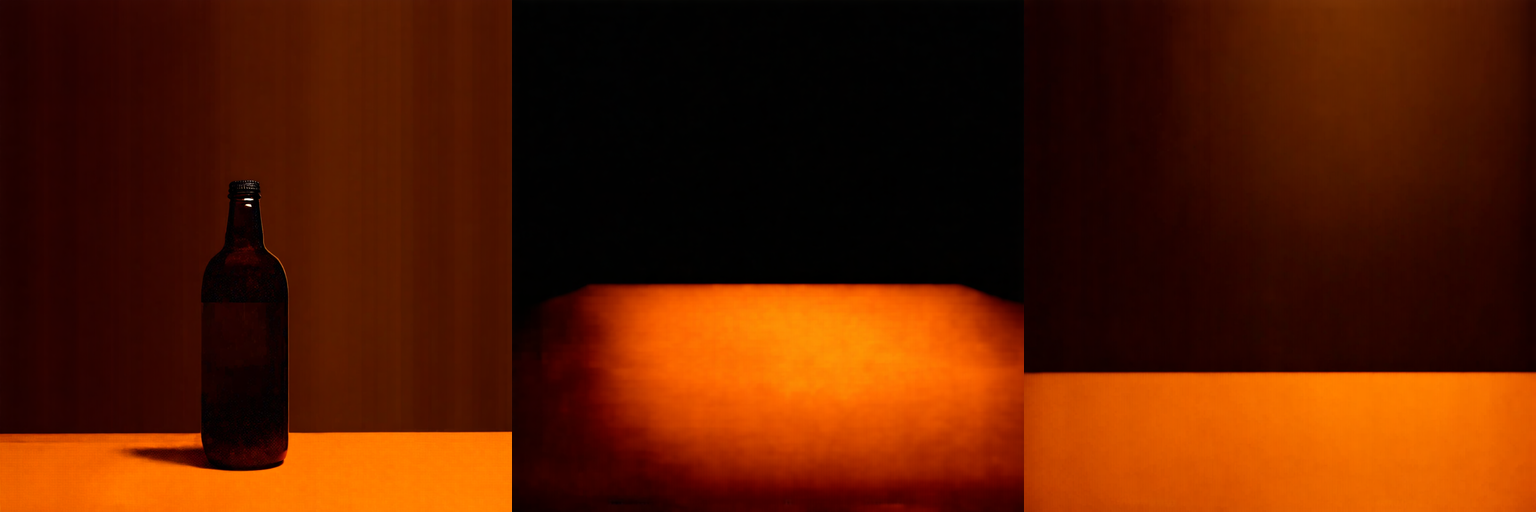

In [ ]:
import datetime
from torch.amp import autocast
# prompt = "a photo of the bottle on a wooden table"#tbhwbx #in the style of Realism
# 适用于训练了风格的LoRA
prompt = f"a photo of a bottle on a wooden table, in the style of {style_name}"
# negative_prompt = "lowres, blurry, bad quality, deformed, ugly"
guidance_scale = 5
num_inference_steps = 150
height = 512
width = 512
generator = torch.Generator(device="cuda").manual_seed(3434554)

num_cols = 3
all_images = []
for _ in range(num_cols):
    with autocast(device_type="cuda", dtype=torch.bfloat16):
        images = pipeline(
            prompt=prompt,
            # negative_prompt=negative_prompt,
            # height=height,
            # width=width,
            # guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            generator=generator,
        ).images
        all_images.extend(images)

grid = image_grid(all_images, rows=1, cols=num_cols, size=512)
images_dir = os.path.join(lora_dir, "lora_generated_images")
os.makedirs(images_dir, exist_ok=True)
grid.save(os.path.join(images_dir, f"lora_results_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"))
display(grid)

# 采样改进

In [ ]:
import torch
from diffusers import StableDiffusion3Pipeline, FlowMatchEulerDiscreteScheduler
from diffusers.models.attention_processor import AttnProcessor

class DiffInjectionProcessor(AttnProcessor):
    """自定义注意力处理器，用于注入历史差分"""
    
    def __init__(self, base_processor: AttnProcessor):
        self.base = base_processor
        # 1x1 卷积，投影 diff_map 到与 attention 输出通道一致
        self.proj = torch.nn.Conv2d(
            in_channels=base_processor.hidden_size,
            out_channels=base_processor.hidden_size,
            kernel_size=1,
        )
        self.diff_map = None  # 存储当前差分图

    def __call__(self, attn, hidden_states, query, key, value, **kwargs):
        # 原始 attention 结果
        out = self.base(attn, hidden_states, query, key, value, **kwargs)
        # 将 diff_map 投影后叠加
        if self.diff_map is not None:
            ctx = self.proj(self.diff_map)
            out = out + ctx
        return out

    def set_diff_map(self, diff_map):
        """设置当前的差分图"""
        self.diff_map = diff_map
    
    def clear_diff_map(self):
        """清除当前的差分图"""
        self.diff_map = None


def create_diff_injection_pipeline(base_pipe):
    """为管道添加差分注入处理器"""
    # 复制管道避免修改原始管道
    pipe = base_pipe
    # 存储所有注入处理器的引用
    processors = []
    
    # 为transformer中的每个注意力模块添加处理器
    for module in pipe.transformer.modules():
        if hasattr(module, "processor") and isinstance(module.processor, AttnProcessor):
            processor = DiffInjectionProcessor(module.processor)
            module.set_processor(processor)
            processors.append(processor)
    
    # 返回修改后的管道和处理器列表
    return pipe, processors


@torch.no_grad()
def generate_with_diff_injection(pipe, processors, prompt, num_steps=30, guidance_scale=7.5, height=512, width=512):
    """使用差分注入生成图像
    
    Args:
        pipe: 扩散模型管道
        processors: 差分注入处理器列表
        prompt: 文本提示
        num_steps: 推理步数
        guidance_scale: 引导强度
        height: 图像高度
        width: 图像宽度
        
    Returns:
        生成的PIL图像列表
    """
    device = pipe.device
    
    # 文本编码
    prompt_embeds, _, pooled_prompt_embeds, _ = pipe.encode_prompt(
        prompt, prompt, prompt,
        device=device,
        num_images_per_prompt=1,
        do_classifier_free_guidance=True,
    )
    
    # 初始化 latents
    pipe.scheduler.set_timesteps(num_steps)
    in_channels = pipe.transformer.config.in_channels
    vae_scale_factor = 8  # SD3 的VAE下采样因子是8

    initial_noise_level = pipe.scheduler.sigmas[0] if len(pipe.scheduler.sigmas) > 0 else 1.0
    
    latents = torch.randn(
        (1, in_channels, height // vae_scale_factor, width // vae_scale_factor),
        device=device,
        dtype=torch.bfloat16,
    ) * initial_noise_level
    
    # 存储历史状态用于计算差分
    history = []
    
    # 设置进度条（参考官方）
    import sys
    is_notebook = 'ipykernel' in sys.modules
    
    from tqdm.auto import tqdm
    from tqdm.notebook import tqdm as tqdm_notebook
    
    if is_notebook:
        progress_bar = tqdm_notebook(pipe.scheduler.timesteps)
    else:
        progress_bar = tqdm(pipe.scheduler.timesteps)
    
    for t in progress_bar:
        history.append(latents.clone())
        
        # 计算差分图
        if len(history) >= 3:
            diff_map = history[-3] - history[-2]
            # 为每个处理器设置当前差分图
            for processor in processors:
                processor.set_diff_map(diff_map)
        else:
            # 首次迭代时没有足够的历史记录，使用零张量
            for processor in processors:
                processor.set_diff_map(torch.zeros_like(latents))
            
        # 扩展批次
        latent_input = torch.cat([latents] * 2)
        batch_size = latent_input.shape[0]
        
        # 创建时间步张量
        timesteps = torch.full((batch_size,), t, device=device, dtype=torch.long)
  
        # 可选的输入缩放
        if hasattr(pipe.scheduler, "scale_model_input"):
            latent_input = pipe.scheduler.scale_model_input(latent_input, timesteps)
        
        # transformer 预测
        out = pipe.transformer(
            hidden_states=latent_input,
            timestep=timesteps,
            encoder_hidden_states=prompt_embeds,
            pooled_projections=pooled_prompt_embeds,
        )
        noise_pred = out.sample

        # guidance
        uncond_pred, text_pred = noise_pred.chunk(2)
        noise_pred = uncond_pred + guidance_scale * (text_pred - uncond_pred)

        # step
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
        
        # 清除当前差分图
        for processor in processors:
            processor.clear_diff_map()

    # 解码
    latents = latents / pipe.vae.config.scaling_factor
    imgs = pipe.vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.cpu().permute(0, 2, 3, 1).float().numpy()

    return pipe.numpy_to_pil(imgs)

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\WZH\.conda\envs\zihaopytorch\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [ ]:
# 加载模型
model_id = "stabilityai/stable-diffusion-3.5-medium"
pipe = StableDiffusion3Pipeline.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
)
pipe.enable_attention_slicing()
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("已启用xFormers高效注意力")
except:
    print("无法启用xFormers")

pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import datetime,os
from torch.amp import autocast
save_path = "./sd3-lora-style"

prompt = "A futuristic cityscape at dusk"
# negative_prompt = "lowres, blurry, bad quality, deformed, ugly"
guidance_scale = 4.5
num_inference_steps = 50
height = 512
width = 512
generator = torch.Generator(device="cuda").manual_seed(3434554)
diff_pipe, processors = create_diff_injection_pipeline(pipe)

num_cols = 3
all_images = []
for _ in range(num_cols):
    with autocast(device_type="cuda", dtype=torch.bfloat16):
        images = generate_with_diff_injection(
            diff_pipe,
            processors,
            prompt=prompt, 
            num_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            height=height,
            width=width
        )
        all_images.extend(images)

grid = image_grid(all_images, rows=1, cols=num_cols, size=512)
images_dir = os.path.join(save_path, "diff_injection_images")
os.makedirs(images_dir, exist_ok=True)
grid.save(os.path.join(images_dir, f"diff_injection_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"))
display(grid)